---
title: "CS 546: Homework 1"
author: "Trent VanHawkins"
date: today
format: 
    pdf:
        geometry: "margin=0.75in"
        mathspec: true
        code-overflow: wrap
        cap-location: bottom
        tbl-cap-location: bottom
        header-includes: 
        - \usepackage{fancyhdr, amsthm, amssymb,amsfonts,amsthm, amsmath, bbm, xcolor}
        - \usepackage{float, tabularx}
        - \floatplacement{table}{H}
        - \pagestyle{fancy}
        - \fancyhead[R]{Homework 1}
        - \fancyhead[L]{Trent VanHawkins}
        - \fancyfoot[C]{\thepage} # Center page number at bottom of each page
page-layout: full
execute: 
  eval: true
---

In this homework assignment, you will be analyzing the human metabolic network. A simplified version of that network is provided for you in edge-list format in a two-column, tab-delimited text file `hsmetnet.txt` that is available at the following URL:  
[https://csx46.s3-us-west-2.amazonaws.com/hsmetnet.txt](https://csx46.s3-us-west-2.amazonaws.com/hsmetnet.txt)
In case you want to check that you have a complete and uncorrupted version of the file, here is it's MD5 checksum: `50bc7295c1f727cdc5867e4853a27583`. An example of the `hsmetnet.txt` file format is shown here:
```
alkylated DNA   REACTION1
REACTION1       DNAn
REACTION1       alkylated nucleobase
acetyl-CoA      REACTION2
1-alkyl-2-lyso-sn-glycero-3-phosphocholine      REACTION2
REACTION2       1-alkyl-2-acetyl-sn-glycero-3-phosphocholine
REACTION2       coenzyme A
deoxyribonucleoside triphosphate        REACTION3
(deoxynucleotides)(n)   REACTION3
```
You will see that there are two types of nodes; nodes that start with `REACTION` and nodes that do not. The former represent chemical *reactions*, and the latter represent *metabolites*. This graph is directed, so the ordering of the nodes is important; a row of the form
```
some-metabolite    REACTION523
```
is saying that metabolite `some-metabolite` is an *input* to (i.e., a reactant for) reaction `REACTION523`. Conversely, a row of the form
```
REACTION634    another-metabolite
```
is saying that metabolite `another-metabolite` is an *output* of (i.e., a product of) reaction `REACTION634`. A graph with two classes of nodes (and for which the only allowed edges are *between* nodes of the two classes, never *among* nodes of a single class) is called *bipartite*. So in this homework assignment we will be analyzing the human metabolic network as a bipartite graph.

You will need to submit your homework assignment as either a Jupyter notebook (preferred) or a PDF of a report showing both code *and* results from running the code.

For this homework assignment, you will need cairo, igraph, pandas, matplotlib, and numpy

In [135]:
import cairo

import igraph
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Next, you will want to download the metabolic network from the CSX46 S3 bucket into your Google Colab instance:

In [136]:
!curl https://csx46.s3-us-west-2.amazonaws.com/hsmetnet.txt \
    --output ../DataRaw/hsmetnet.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  632k  100  632k    0     0  4293k      0 --:--:-- --:--:-- --:--:-- 4302k


Next, read in the metabolic network as an edge-list (hint: use `read_csv` from `pandas`) into a `pandas.DataFrame`. Name the two columns `source` and `target`. Show the first six rows of the data frame. Note, there are some duplicate rows in the data file (for whatever reason) so you will want to use the `drop_duplicates` method on the Pandas data frame.

In [137]:
hsmetnet = pd.read_csv(filepath_or_buffer= "../DataRaw/hsmetnet.txt", sep= "\t", names= ["source", "target"]).drop_duplicates()
hsmetnet.head(6)

,source,target
0,alkylated DNA,REACTION1
1,REACTION1,DNAn
2,REACTION1,alkylated nucleobase
3,acetyl-CoA,REACTION2
4,1-alkyl-2-lyso-sn-glycero-3-phosphocholine,REACTION2
5,REACTION2,1-alkyl-2-acetyl-sn-glycero-3-phosphocholine


Next, you will want to construct an igraph Graph from the pandas dataframe (hint: use `Graph.TupleList` with `directed=True`; you can use  `.values.tolist()` on the Pandas dataframe

In [138]:
hs_graph = igraph.Graph.TupleList(hsmetnet.values.tolist(), directed= True)

\textcolor{orange}{\textbf{Question:} \textit{How many distinct metabolites are there in the graph?How many reactions How many edges are there? }}

(hint: use list comprehension, `in`, `for`, `len`, `str`, `set`, and `shape`)

(You can assume that no metabolite name has "REACTION" as a substring).

In [139]:
# Assign types to the vertices (bipartite)
vtype = ["reaction" if name.startswith("REACTION") else 
"metabolite" for name in hs_graph.vs["name"]]
hs_graph.vs["type"] = vtype

# Subset metabolites to count them
metabs = [(v["name"], v.indegree() + v.outdegree()) for v in hs_graph.vs if v["type"] == "metabolite"]
n_metabs = len(set(metabs))

#Count the reactions
reactions = [(v["name"], v.indegree() + v.outdegree()) for v in hs_graph.vs if v["type"] == "reaction"]
n_reactions = len(set(reactions))

#Count the edges
n_edges = hs_graph.ecount()

# Print the answers to the question.
print("There are", n_metabs, "distinct metabolites,", 
n_reactions, "reactions, and", 
n_edges, "edges in this graph.", sep = " ")

There are 2340 distinct metabolites, 5539 reactions, and 19537 edges in this graph.


\textcolor{orange}{\textbf{Question:}\textit{In this graph, what are the top six metabolites in terms of vertex degree? (indegree+outdegree counted together)}}

(hint: use list comprehension, `for`, `enumerate`, `sorted` (with `reverse=True`), and `lambda` or `itemgetter`)

In [140]:
sorted(metabs, key=lambda x: x[1], reverse=True)[0:6]

[('ATP', 1202),
 ('ADP', 967),
 ('phosphate', 562),
 ('[protein] (L-serine/L-threonine) phosphate', 383),
 ('[protein]-(L-serine/L-threonine)', 383),
 ('coenzyme A', 379)]

\textcolor{orange}{\textbf{Task:}\textit{Plot the distribution of the degrees of all of the metabolite vertices, on log-log scale*  (indegree+outdegree counted together).}}

(hint: use `degree_distribution` in igraph, with `vertices=metabolite_inds`; use the `.bins()` method to get the bin counts out; you can use `matplotlib.pyplot.loglog` to plot)

(hint: do not try to plot bin counts of zero, as they cannot be plotted on a log scale; those zero counts should be removed before plotting)

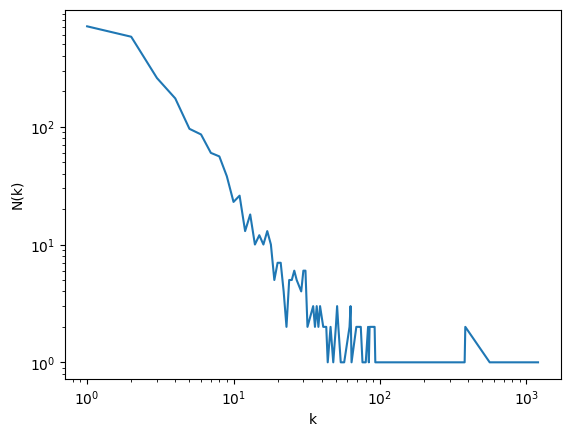

In [141]:
metabolite_inds = [idx for idx, v in enumerate(hs_graph.vs()) if v["type"] == "metabolite"]

bin_counts = hs_graph.degree_distribution(vertices = metabolite_inds).bins()

xs, ys = zip(*[(left, count) for left, _, count in
         bin_counts if count > 0])
plt.loglog(xs, ys)
plt.xlabel("k")    # Changed from set_xlabel
plt.ylabel("N(k)") # Changed from set_ylabel
plt.show()

\textcolor{orange}{\textbf{Question:}\textit{what is the exponent α of the best-fit power-law to the degree distribution?}}

(hint: use `igraph.statistics.power_law_fit`, and on the object that is returned, get the value of the `.alpha` variable)

In [142]:
degrees = hs_graph.degree()

fit = igraph.statistics.power_law_fit(degrees)

print(f"Alpha: {round(fit.alpha, 3)}")
print(f"p-value: {fit.p}")

Alpha: 2.025
p-value: 0.9292


\textcolor{orange}{\textbf{Conceptual Question:}\textit{ How does the α that you get compare to the estimate of the power-law exponent reported by Jeong et al. in their 2000 article in Nature, “The large-scale organization of metabolic networks” (vol. 407, pp. 651–654) (see page 14 of reading-for-class-06.pdf)? Based on structure of the network that you analyzed (bipartite, containing reactions) vs. the structure of the network that they analyzed (network projected to a network containing only metabolites), is it appropriate to compare the exponents? Why or why not?}}

(You may also find page 12 of the supplementary material for the Jeong et al. article useful; that can be found [here](https://drive.google.com/file/d/1mEY3ikVKwUMVBiQDcM7-G-n1FFphm8LK/view?usp=share_link)).

\textcolor{darkgray}{Jeong et al. reports $\alpha_1 \approx 2.2$ while we found $\alpha_2 \approx 2.02$. Since the degree distribution of both networks follows a power-law distribution, they may both be described as scale-free. On the other hand, since the network in their paper has been projected to a network containing only metabolites, all metabolites that participate in the same reaction will have an edge, meaning metabolite nodes will tend to have a larger degree.}



\textcolor{orange}{\textbf{Task:}\textit{calculate the shortest-path-lengths between all pairs of metabolites (vertices) in the giant weakly connected component of the graph, discarding direction information in the graph.}}

(hint: use `igraph.Graph.connected_components` with `mode=weak` to get the giant weakly-connected component; then use `components.membership` to get a list (of length equal to the number of vertices) specifying which component each vertex is a member of. Then call `sizes()` on the object returned from `connected_components()` to get the sizes of each component, and use `numpy.argmax` to confirm that component 0 is the giant component. Then use `enumerate` to get the giant component members; then use `igraph.Graph.distances` with `mode=igraph.ALL`, with
`source=<metabolite_vertex_indices>` and `target=<metabolite_vertex_indices>` to get the
all-pairs-shortest-paths.)

In [143]:
#Compute the components
components = hs_graph.connected_components(mode="weak")
#Compute the component membership
membership = np.array(components.membership)
#Extract component sizes
component_sizes = components.sizes()

#Which is the giant component?
giant_component_idx = np.argmax(component_sizes)

#Extract the indices of the metabolites in the giant component
metabolites_in_GC = np.array(metabolite_inds)[membership[np.array(metabolite_inds)] == 
                                              giant_component_idx]

#Compute all pairs shortest path lengths between the metabolites in the giant component
all_pairs_dists = hs_graph.distances(mode=igraph.ALL, 
                                     source=metabolites_in_GC, 
                                     target=metabolites_in_GC)

\textcolor{orange}{\textbf{Question:}\textit{What is the average of the shortest-path-lengths between all pairs of metabolites in the giant (weakly connected) component of the network?}}

(Note: in calculating your average, do not include pairs of vertices that are the same vertex as both source and destination, which would have a distance of zero)

(hint: Use `numpy.array`, `numpy.isfinite` and `numpy.mean` to get the mean distance; throw away any shortest-paths distance value if it is infinite.)

In [144]:
#Convert to numpy array and filter out inf and 0 values
all_pairs_arr = np.array(all_pairs_dists)
all_pairs_arr = all_pairs_arr[all_pairs_arr != np.inf]
all_pairs_arr = all_pairs_arr[all_pairs_arr != 0]

# Compute and print the average shortest path length
print("Average shortest path length:", round(np.mean(all_pairs_arr), 3))


Average shortest path length: 6.799


\textcolor{orange}{\textbf{Question:}\textit{What is the maximum of the shortest-path-length between all pairs of metabolites (throwing away infinite values, as before) in the giant (weakly connected) component of the network?}}

(hint: use `numpy.max` and `numpy.isfinite`; Note, you are calculating the diameter of the giant component)

In [145]:
print("The maximum shortest path length (diameter) is:", np.max(all_pairs_arr))

The maximum shortest path length (diameter) is: 18


\textcolor{orange}{\textbf{Conceptual Question:}\textit{Why are the average geodesic distances that we get, roughly twice those reported in Fig. 3b of Jeong et al., 2000?}}

\textcolor{darkgray}{We computed the shortest path distance ignoring direction. So if there was an edge from A to B, we computed the shortest path from A to B and from B to A and averaged over both. We could average over just the upper-traingle of our distance matrix if we want to not count each twice.}


\textcolor{orange}{\textbf{Task:}\textit{Calculate the shortest-paths betweenness centrality for all metabolites in the directed network.}}

(hint: use the `betweenness` function with the `vertices=<vector of vertex indices>` option, with `directed=True`)

In [146]:
betweenness = hs_graph.betweenness(vertices=metabolite_inds, directed=True)


\textcolor{orange}{\textbf{Task:}\textit{plot the scatter plot of betweenness centrality vs. vertex degree for all metabolites, on log-log scale. (In the plot, normalize your betweenness centrality values by dividing by $M^2$ where $M$ is the number of metabolites.)}}

(hint:  use `numpy.array`, `numpy.where`, and `matplotlib.pyplot.scatter`)

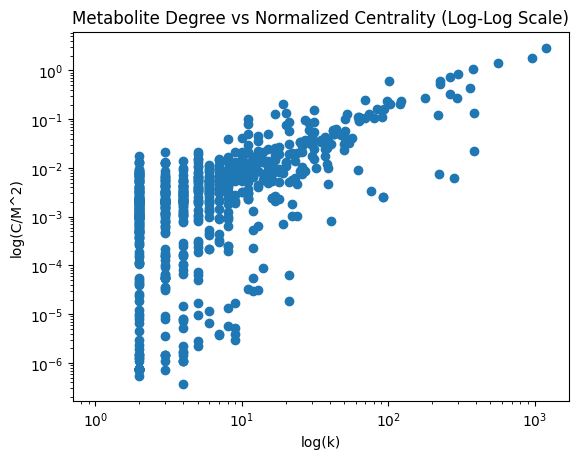

In [147]:
#Convert to numpy arrays
degree_arr = np.array(degrees)
betweenness_arr = np.array(betweenness)

#Subset to metabolites only
degree_metabolites = degree_arr[metabolite_inds]

#Normalize
betweenness_norm = betweenness_arr/len(metabolite_inds)**2

plt.figure()
plt.scatter(degree_metabolites, betweenness_norm) 
plt.xscale('log') 
plt.yscale('log') 
plt.title('Metabolite Degree vs Normalized Centrality (Log-Log Scale)')
plt.xlabel('log(k)')
plt.ylabel('log(C/M^2)')

# Display the plot
plt.show()


\textcolor{orange}{\textbf{Question:}\textit{Among metabolites with degree k=2 , what metabolite has highest betweenness centrality in the network?}}

(hint:  use `numpy.argmax` and `numpy.where`)

In [148]:
metabs_name = [v["name"] for v in hs_graph.vs if v["type"] == "metabolite"]
idx_k2 = np.where(degree_metabolites == 2)[0]
max_centrality_idx = np.argmax(betweenness_arr[idx_k2])
original_idx = idx_k2[max_centrality_idx]
print("The metabolite of degree 2 with the highest betweenness centrality is", 
      metabs_name[original_idx], sep = " ")

The metabolite of degree 2 with the highest betweenness centrality is L-arginino-succinate


\textcolor{orange}{\textbf{Task:}\textit{Search on this metabolite in the HumanCyc database at [humancyc.org](https://humancyc.org), using the "Quick Search" box. Click on the hyperlinked metabolite that is displayed on the search results page. Click on the "reactions" tab, in the tabbed window in the lower part of the page. What important metabolic cycles is this metabolite involved in? Click on the "urea cycle". What is the known consequence of absence of an enzyme in this pathway?}}

\textcolor{darkgray} {L-arginino-succinate is involved in nitric oxide biosynthesis II and in the urea cycle. From humancyc.org: "Absence of any urea cycle enzyme is lethal. Congenital deficiencies of any of the enzymes of the urea cycle or liver failure cause hyperammonemia, characterized by mental retardation and lethargy."}